In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fd7bf6b3be0>,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [10]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fd7bf6b3eb0>,
 'id': 1,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US'}

In [11]:
#most recent date - using an order by for date, descending order, getting the first result back
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [12]:
#finding a year before the most recent date
year_before = (dt.date(2017, 8, 23) - dt.timedelta(days=365)).strftime('%Y-%m-%d')
year_before

'2016-08-23'

In [13]:
# getting precipitation data for last 12 months in dataset
dates_list = []
precips_list = []
pdata = session.query(Measurement).filter(Measurement.date >= year_before).all()
for row in pdata:
    dates_list.append(row.date)
    precips_list.append(row.prcp)

In [14]:
#replacing NaNs with zeros
precips_list_fix = [0 if x == None else x for x in precips_list]
#finding highest val in precip list
max(precips_list_fix)

6.7

In [15]:
#creating df out of dates and precipitation lists
#setting index as date
#sorting index (dates)
prcp_data = pd.DataFrame(
    {'date': dates_list, 'precipitation': precips_list_fix}
    ).set_index('date').sort_index()
prcp_data.head(10)

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


In [16]:
#creating a list of all the unique dates in the df to see if the x axis in the graph can be labelled for every nth value
each_date = [x for x in prcp_data.index.unique()]

In [17]:
#for loop to see how many rows there are per date - they vary, so it can't be used to mark the x axis for every nth value
num_measurements = []
for item in each_date:
    length = len(prcp_data[prcp_data.index == item])
    num_measurements.append(length)
#num_measurements

[7,
 7,
 7,
 6,
 6,
 6,
 7,
 6,
 7,
 6,
 7,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 5,
 5,
 7,
 7,
 7,
 7,
 7,
 5,
 5,
 7,
 7,
 6,
 7,
 7,
 6,
 6,
 7,
 6,
 7,
 7,
 7,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 5,
 5,
 6,
 7,
 6,
 7,
 6,
 6,
 5,
 7,
 7,
 7,
 6,
 7,
 5,
 6,
 7,
 7,
 6,
 7,
 7,
 6,
 6,
 7,
 6,
 6,
 6,
 7,
 6,
 6,
 7,
 6,
 7,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 5,
 4,
 5,
 6,
 7,
 6,
 5,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 7,
 6,
 7,
 7,
 6,
 6,
 5,
 7,
 7,
 7,
 7,
 7,
 5,
 6,
 7,
 7,
 7,
 7,
 7,
 6,
 5,
 6,
 6,
 7,
 7,
 7,
 5,
 6,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 6,
 6,
 6,
 5,
 5,
 6,
 6,
 7,
 7,
 7,
 6,
 5,
 7,
 6,
 7,
 7,
 7,
 5,
 5,
 7,
 7,
 7,
 7,
 6,
 5,
 6,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 7,
 6,
 7,
 7,
 6,
 5,
 4,
 6,
 6,
 7,
 7,
 7,
 4,
 6,
 7,
 7,
 7,
 6,
 7,
 5,
 4,
 7,
 6,
 6,
 7,
 7,
 5,
 5,
 7,
 7,
 6,
 7,
 6,
 6,
 5,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 6,
 7,
 7,
 6,
 7,
 6,
 6,
 7,
 7,
 7,
 7,
 6,
 4,
 6,
 7,
 7,
 7,
 7,
 6,
 5,
 5,
 7,
 7,
 7,
 7,
 7,
 5,
 4,
 7,
 7,
 6,
 7,
 7,
 6,


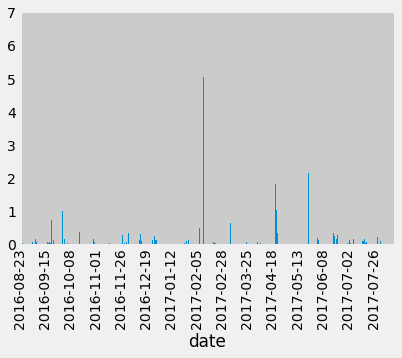

In [18]:
ax = prcp_data.plot(
    kind='bar', legend=False, rot=90, grid=True
    )
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 150) != 0:
        t.set_visible(False)

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data.describe()

,precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number stations in the dataset


In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [24]:
# Close Session
#session.close()